In [1]:
import os
os.environ['DDE_BACKEND']='pytorch'

!pip install deepxde

import deepxde as dde
import numpy as np
from deepxde.backend import torch

In [2]:
# Diffusion equation u(x,t)
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
         dy_t
         - dy_xx
         + torch.exp(-x[:, 1:])
         * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
     )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net_default = dde.nn.FNN(layer_size, activation, initializer)

In [12]:
# 纯PINN
net_1 = dde.nn.FNN(layer_size, activation, initializer)
net_1.load_state_dict(net_default.state_dict())
model_1 = dde.Model(data, net_1)
model_1.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory_1, train_state_1 = model_1.train(iterations=1000, display_every=100)


Compiling model...
'compile' took 0.003449 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.58e+01, 1.26e-01, 6.69e-01]    [1.70e+01, 1.26e-01, 6.69e-01]    [1.36e+00]    
100       [1.54e+00, 3.25e-02, 3.04e-02]    [1.08e+00, 3.25e-02, 3.04e-02]    [3.18e-01]    
200       [1.25e-01, 3.61e-02, 4.41e-03]    [7.50e-02, 3.61e-02, 4.41e-03]    [2.18e-01]    
300       [6.01e-02, 3.47e-02, 4.31e-03]    [3.58e-02, 3.47e-02, 4.31e-03]    [2.23e-01]    
400       [3.17e-02, 2.60e-02, 3.75e-03]    [2.48e-02, 2.60e-02, 3.75e-03]    [1.96e-01]    
500       [1.98e-02, 1.67e-02, 2.52e-03]    [1.95e-02, 1.67e-02, 2.52e-03]    [1.60e-01]    
600       [1.15e-02, 1.02e-02, 1.72e-03]    [1.27e-02, 1.02e-02, 1.72e-03]    [1.27e-01]    
700       [6.48e-03, 6.23e-03, 1.46e-03]    [8.57e-03, 6.23e-03, 1.46e-03]    [1.03e-01]    
800       [4.76e-03, 4.37e-03, 1.24e-03]    [6.53e-03, 4.37e-03, 1.24e-03]    [8.79e-02]    
900  

In [11]:
# PINN + resample
net_2 = dde.nn.FNN(layer_size, activation, initializer)
net_2.load_state_dict(net_default.state_dict())
model_2 = dde.Model(data, net_2)
resampler = dde.callbacks.PDEPointResampler(period=500)
model_2.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory_2, train_state_2 = model_2.train(iterations=1000, callbacks=[resampler], display_every=100)


Compiling model...
'compile' took 0.000225 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.58e+01, 1.26e-01, 6.69e-01]    [1.70e+01, 1.26e-01, 6.69e-01]    [1.36e+00]    
100       [1.60e+00, 2.78e-02, 3.73e-02]    [1.09e+00, 2.78e-02, 3.73e-02]    [3.11e-01]    
200       [1.40e-01, 3.92e-02, 5.01e-03]    [7.92e-02, 3.92e-02, 5.01e-03]    [2.29e-01]    
300       [5.81e-02, 3.66e-02, 5.75e-03]    [3.41e-02, 3.66e-02, 5.75e-03]    [2.29e-01]    
400       [3.25e-02, 2.70e-02, 4.81e-03]    [2.41e-02, 2.70e-02, 4.81e-03]    [1.98e-01]    
500       [2.30e-02, 1.77e-02, 3.16e-03]    [2.26e-02, 1.77e-02, 3.16e-03]    [1.62e-01]    
600       [1.58e-02, 1.24e-02, 2.06e-03]    [1.70e-02, 1.24e-02, 2.06e-03]    [1.37e-01]    
700       [9.35e-03, 7.55e-03, 1.28e-03]    [1.15e-02, 7.55e-03, 1.28e-03]    [1.09e-01]    
800       [5.63e-03, 4.55e-03, 9.64e-04]    [7.56e-03, 4.55e-03, 9.64e-04]    [8.75e-02]    
900  

In [18]:
# PINN + hard_bc
net_3 = dde.nn.FNN(layer_size, activation, initializer)
net_3.load_state_dict(net_default.state_dict())
net_3.apply_output_transform(
    # Backend pytorch
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
)
model_3 = dde.Model(data, net_3)
model_3.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory_3, train_state_3 = model_3.train(iterations=1000, display_every=100)


Compiling model...
'compile' took 0.000172 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.07e+00, 1.16e-15, 3.55e-16]    [8.84e+00, 1.16e-15, 3.55e-16]    [6.53e-01]    
100       [3.15e-01, 1.16e-15, 3.55e-16]    [4.09e-01, 1.16e-15, 3.55e-16]    [9.71e-02]    
200       [1.04e-01, 1.16e-15, 3.55e-16]    [1.39e-01, 1.16e-15, 3.55e-16]    [4.63e-02]    
300       [4.34e-02, 1.16e-15, 3.55e-16]    [5.96e-02, 1.16e-15, 3.55e-16]    [2.56e-02]    
400       [1.38e-02, 1.16e-15, 3.55e-16]    [1.97e-02, 1.16e-15, 3.55e-16]    [1.26e-02]    
500       [4.33e-03, 1.16e-15, 3.55e-16]    [6.92e-03, 1.16e-15, 3.55e-16]    [9.07e-03]    
600       [2.42e-03, 1.16e-15, 3.55e-16]    [4.20e-03, 1.16e-15, 3.55e-16]    [8.27e-03]    
700       [1.81e-03, 1.16e-15, 3.55e-16]    [3.24e-03, 1.16e-15, 3.55e-16]    [7.23e-03]    
800       [1.45e-03, 1.16e-15, 3.55e-16]    [2.60e-03, 1.16e-15, 3.55e-16]    [6.10e-03]    
900  

In [23]:
# PINN + resample + hard_bc
net_4 = dde.nn.FNN(layer_size, activation, initializer)
net_4.load_state_dict(net_default.state_dict())
net_4.apply_output_transform(
    # Backend pytorch
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
)
model_4 = dde.Model(data, net_4)
model_4.compile("adam", lr=0.001, metrics=["l2 relative error"])

resampler = dde.callbacks.PDEPointResampler(period=500)
losshistory_4, train_state_4 = model_4.train(iterations=1000, callbacks=[resampler], display_every=100)


Compiling model...
'compile' took 0.000205 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.00e+00, 1.16e-15, 3.55e-16]    [8.84e+00, 1.16e-15, 3.55e-16]    [6.53e-01]    
100       [3.05e-01, 1.16e-15, 3.55e-16]    [3.78e-01, 1.16e-15, 3.55e-16]    [9.23e-02]    
200       [8.81e-02, 1.16e-15, 3.55e-16]    [1.12e-01, 1.16e-15, 3.55e-16]    [3.94e-02]    
300       [3.50e-02, 1.16e-15, 3.55e-16]    [4.60e-02, 1.16e-15, 3.55e-16]    [2.53e-02]    
400       [9.33e-03, 1.16e-15, 3.55e-16]    [1.27e-02, 1.16e-15, 3.55e-16]    [1.19e-02]    
500       [2.91e-03, 1.16e-15, 3.55e-16]    [4.98e-03, 1.16e-15, 3.55e-16]    [6.91e-03]    
600       [1.99e-03, 1.16e-15, 3.55e-16]    [3.76e-03, 1.16e-15, 3.55e-16]    [5.44e-03]    
700       [1.63e-03, 1.16e-15, 3.55e-16]    [3.04e-03, 1.16e-15, 3.55e-16]    [4.38e-03]    
800       [1.36e-03, 1.16e-15, 3.55e-16]    [2.48e-03, 1.16e-15, 3.55e-16]    [3.60e-03]    
900  

In [8]:
import matplotlib.pyplot as plt

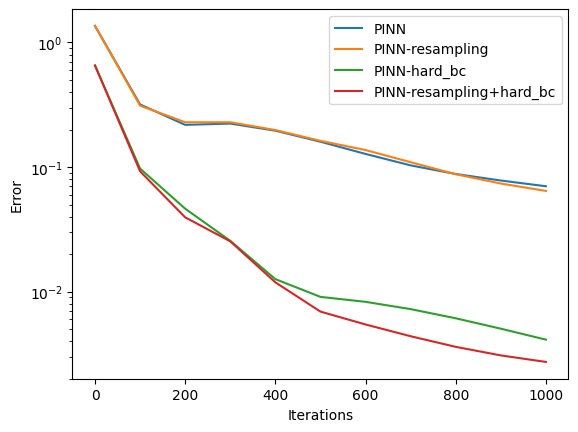

In [24]:
loss_history_list = [losshistory_1, losshistory_2, losshistory_3, losshistory_4]
labels = ["PINN", "PINN-resampling","PINN-hard_bc","PINN-resampling+hard_bc"]
plt.figure()
for idx, loss_history in enumerate(loss_history_list):
  for i in range(len(loss_history.metrics_test[0])):
    plt.semilogy(
        loss_history.steps,
        np.array(loss_history.metrics_test)[:, i],
        label=labels[idx],
    )
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.legend()
plt.show()